In [2]:
import sys
if "/Users/raymond/code/FinalProject563" not in sys.path:
    sys.path.append("/Users/raymond/code/FinalProject563")
import torch
import pickle
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas
import time
import os

import connect_four
import mcts
import connect_net
import connect_plot
import evaluation
import utils
import runner
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
os.chdir("/Users/raymond/code/FinalProject563")
trial = "test01"
networks = {}
for i in range(1, 64):
    iteration = i
    training_folder = utils.get_training_folder(trial=trial, iteration=iteration)
    training_path = runner.get_model_path(folder=training_folder, iteration=iteration)
    nnet = connect_net.load_model(path=training_path, log=False)
    networks[i] = nnet
nnetp = connect_net.load_model(path="models/pretrain01.model", log=False)
networks["p"] = nnetp
print(len(networks))

64


In [5]:
scores = {k: 1600 for k in networks.keys()}
num_mcts_sims = 32
k = 32
list_df = []

In [6]:
for g in range(0, 200):
    if g % 10 == 0:
        print(g)
    sorted_players = sorted(scores.items(), key=lambda x: x[1])
    pairs = []
    for i in range(len(sorted_players)//2):
        pair = tuple(sorted_players[2*i:2*i+2])
        pairs.append(pair)
    for (p1, p1_rating), (p2, p2_rating) in pairs:
        result = evaluation.competition_game(
            player1=networks[p1], p1_mcts_sims=num_mcts_sims,
            player2=networks[p2], p2_mcts_sims=num_mcts_sims,
            random_move=4,
        )
        R1 = 10**(p1_rating / 400)
        R2 = 10**(p2_rating / 400)
        Rtotal = R1 + R2
        e1 = R1 / Rtotal
        e2 = R2 / Rtotal
        if result[0] == "player1":
            s1, s2 = 1, 0
        elif result[0] == "player2":
            s1, s2 = 0, 1
        else:
            s1, s2 = 0.5, 0.5
        scores[p1] = p1_rating + k * (s1 - e1)
        scores[p2] = p2_rating + k * (s2 - e2)
    df_tmp = pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"])
    df_tmp["iteration"] = g
    list_df.append(df_tmp)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


<AxesSubplot:xlabel='iteration'>

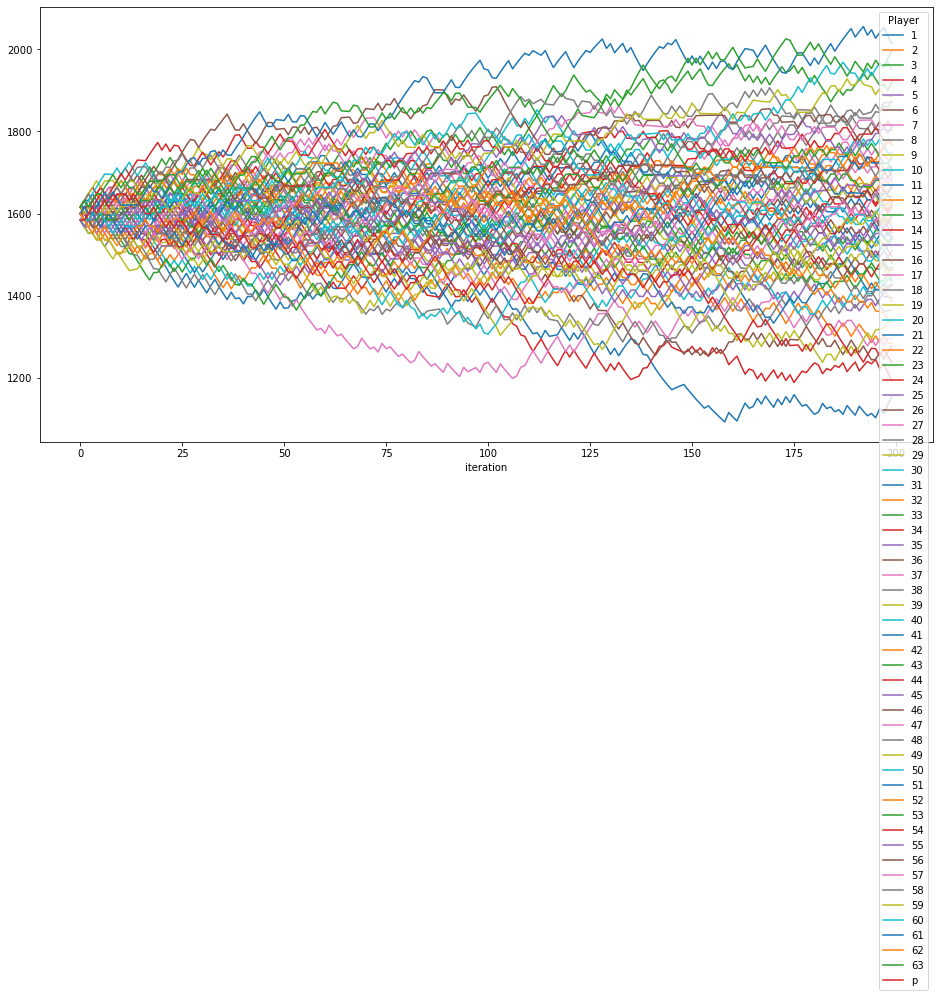

In [7]:
df_all = pandas.concat(list_df)
df_all.pivot("iteration", "Player", "ELO").plot(figsize=(16, 8))

In [8]:
pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"]).sort_values("ELO", ascending=False).head(10)

,Player,ELO
60,61,2014.561425
62,63,1996.613231
59,60,1949.538434
32,33,1919.487543
58,59,1884.777128
57,58,1873.638922
27,28,1871.171314
56,57,1815.015204
54,55,1810.889787
55,56,1810.873810


/Users/raymond/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='Player'>

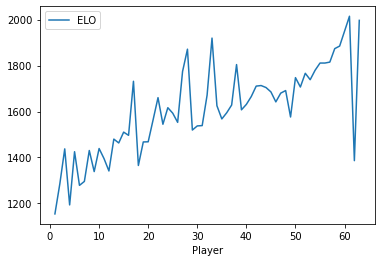

In [12]:
pandas.DataFrame(list(scores.items()), columns=["Player", "ELO"]).iloc[:-1].plot(x="Player", y="ELO")

In [84]:
num_mcts_sims = 32
results = []
for i in range(100):
    result = evaluation.competition_game(
        player1=networks[1], p1_mcts_sims=num_mcts_sims, 
        player2=networks[63], p2_mcts_sims=num_mcts_sims,
        random_move=4,
    )
    results.append(result)

In [85]:
df_results = pandas.DataFrame([(r[0], r[1]) for r in results], columns=["Winner", "moves"])
df_results["Winner"].value_counts()

player2    67
player1    23
Draw       10
Name: Winner, dtype: int64

In [13]:
num_mcts_sims = 32
random_move = 0

gc = connect_four.GameCache()
p1_nc = connect_net.NetworkCache(nnet=networks[63])
p1_mcts = mcts.MCTS(c=1, game_cache=gc, network_cache=p1_nc)

# offset = random.randint(0, 1)
offset = 1
move = 1
state = connect_four.start_state()
rep = connect_four.to_rep(state=state)

<Figure size 432x288 with 0 Axes>

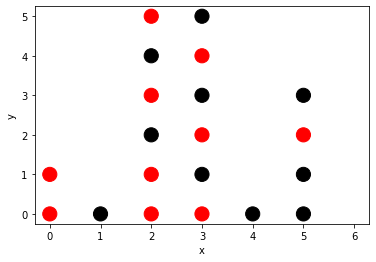

In [54]:
connect_plot.print_board((-1)**(move + offset)*state)

In [55]:
if (move + offset) % 2 == 1:
    p1_mcts.simulate_moves(num_mcts_sims=num_mcts_sims, state=state, rep=rep, nnet=networks[63])
    
    if move <= random_move * 2:
        a, _ = p1_mcts.get_random_action(rep=rep)
    else:
        a = p1_mcts.get_best_action(rep=rep)
else:
    a = int(input("Enter a move"))

print(f"Made move {a}")
next_state, next_rep = gc.next_state_rep(state=state, rep=rep, action=a)
ge = gc.game_ended(state=next_state, rep=next_rep)

if ge is not None:
    print("Game Ended")
    winner = -ge

move += 1
state, rep = next_state, next_rep

Enter a move5
Made move 5


In [21]:
winner = -ge
winner = "Draw" if winner == 0 else ("player1" if (move + offset) % 2 == 1 else "player2")

TypeError: bad operand type for unary -: 'NoneType'